# 2. The Factors

DFA believes certain stocks have higher expected excess returns. In addition to the overall market equity premium, DFA believes that there is a premium attached to a size and value factor. Note that these three factors are already listed as excess returns.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict

DATA_PATH = "dfa_analysis_data.xlsx"   
SHEET_NAME = "factors"                
DATE_COL = "Date"
FACTORS = ["Mkt-RF", "SMB", "HML"]    

SPLIT1_END = "1980-12-31"
SUB2_START = "1981-01-01"
SUB2_END = "2001-12-31"
SUB3_START = "2002-01-01"

In [37]:
def load_and_prepare(path: str, sheet: str = SHEET_NAME) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name=sheet)
    df[DATE_COL] = pd.to_datetime(df[DATE_COL])
    df = df.set_index(DATE_COL).sort_index()

    missing = [c for c in FACTORS if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in sheet '{sheet}': {missing}")
    return df[FACTORS].copy()

def define_subsamples(df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    subsamples = {
        "Full": df,
        "Beginning - 1980": df.loc[:SPLIT1_END],
        "1981 - 2001": df.loc[SUB2_START:SUB2_END],
        "2002 - Present": df.loc[SUB3_START:]
    }
    return subsamples

df = load_and_prepare(DATA_PATH)
subsamples = define_subsamples(df)

## 1. The Factors
Calculate their univariate performance statistics:

- mean
- volatility
- Sharpe
- VaR(.05)

Report these for the following three subsamples:

- Beginning - 1980
- 1981 - 2001
- 2002 - End

In [18]:
def compute_univariate_stats(df: pd.DataFrame) -> pd.DataFrame:
    mean_m = df.mean()
    vol_m = df.std()
    sharpe_m = mean_m / vol_m
    var05_m = df.quantile(0.05)   

    res = pd.DataFrame({
        "Mean (m)": mean_m,
        "Vol (m)": vol_m,
        "Sharpe (m)": sharpe_m,
        "VaR(5%) (m)": var05_m,
    })
    return res

def stats_for_all_subsamples(subsamples: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    stats = {}
    for name, data in subsamples.items():
        stats[name] = compute_univariate_stats(data)
    return stats

stats_dict = stats_for_all_subsamples(subsamples)

for name, table in stats_dict.items():
    print("\n" + "="*60)
    print(f"Stats for: {name}")
    print(table.round(6))


Stats for: Full
        Mean (m)   Vol (m)  Sharpe (m)  VaR(5%) (m)
Mkt-RF  0.006897  0.053155    0.129762     -0.07922
SMB     0.001675  0.031566    0.053075     -0.04180
HML     0.003468  0.035573    0.097485     -0.04241

Stats for: Beginning - 1980
        Mean (m)   Vol (m)  Sharpe (m)  VaR(5%) (m)
Mkt-RF  0.006746  0.059175    0.114009    -0.084090
SMB     0.002826  0.032989    0.085670    -0.041875
HML     0.004193  0.038748    0.108222    -0.044245

Stats for: 1981 - 2001
        Mean (m)   Vol (m)  Sharpe (m)  VaR(5%) (m)
Mkt-RF  0.006488  0.045375    0.142980    -0.064135
SMB    -0.000168  0.033850   -0.004959    -0.045880
HML     0.005380  0.031715    0.169629    -0.041640

Stats for: 2002 - Present
        Mean (m)   Vol (m)  Sharpe (m)  VaR(5%) (m)
Mkt-RF  0.007609  0.044320    0.171678    -0.077265
SMB     0.000661  0.025533    0.025885    -0.039195
HML     0.000100  0.030727    0.003266    -0.041485


## 2.

Based on the factor statistics above, answer the following.

- Does each factor have a premium (positive expected excess return) in each subsample?
- Does the premium to the size factor get smaller after 1980?
- Does the premium to the value factor get smaller during the 1990’s?
- How have the factors performed since the time of the case, (2002-present)?

In [17]:
def positive_premium_report(subsamples: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    out = {}
    for name, data in subsamples.items():
        out[name] = (data.mean() > 0)
    dfpos = pd.DataFrame(out).T
    return dfpos

pos_prem = positive_premium_report(subsamples)
print("\n" + "="*60)
print("Positive premium (monthly mean > 0) by subsample:")
print(pos_prem)


Positive premium (monthly mean > 0) by subsample:
                  Mkt-RF    SMB   HML
Full                True   True  True
Beginning - 1980    True   True  True
1981 - 2001         True  False  True
2002 - Present      True   True  True


In [43]:
hml_80s = df.loc["1981-01-01":"1989-12-31", "HML"].mean()
hml_90s = df.loc["1990-01-01":"1990-12-31", "HML"].mean()

print(f"HML monthly mean (1981-1989): {hml_80s:.6f} (monthly)")
print(f"HML monthly mean (1990): {hml_90s:.6f} (monthly)")

HML monthly mean (1981-1989): 0.007314 (monthly)
HML monthly mean (1990): -0.010208 (monthly)


- The premium to the SMB (size) factor gets smaller after 1980.
- The premium to the HML (value) factor gets smaller during the 1990's.
- The factors have performed since 2002 (2002–present):
  - Market: Strong
  - SMB (size): Remains marginally positive 
  - HML (value): Shows virtually no positive premium

## 3.

The factors are constructed in such a way as to reduce correlation between them.

- Report the correlation matrix across the three factors.
- Does the construction method succeed in keeping correlations small?
- Does it achieve this in each subsample?

In [16]:
def correlation_matrices(subsamples: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    corrs = {}
    for name, data in subsamples.items():
        corrs[name] = data.corr()
    return corrs

corrs = correlation_matrices(subsamples)
for name, c in corrs.items():
    print("\n" + "-"*40)
    print(f"Correlation matrix - {name}")
    print(c.round(4))


----------------------------------------
Correlation matrix - Full
        Mkt-RF     SMB     HML
Mkt-RF  1.0000  0.3204  0.2278
SMB     0.3204  1.0000  0.1258
HML     0.2278  0.1258  1.0000

----------------------------------------
Correlation matrix - Beginning - 1980
        Mkt-RF     SMB     HML
Mkt-RF  1.0000  0.3742  0.4423
SMB     0.3742  1.0000  0.3134
HML     0.4423  0.3134  1.0000

----------------------------------------
Correlation matrix - 1981 - 2001
        Mkt-RF     SMB     HML
Mkt-RF  1.0000  0.1587 -0.5299
SMB     0.1587  1.0000 -0.4455
HML    -0.5299 -0.4455  1.0000

----------------------------------------
Correlation matrix - 2002 - Present
        Mkt-RF     SMB     HML
Mkt-RF  1.0000  0.3160  0.1097
SMB     0.3160  1.0000  0.1162
HML     0.1097  0.1162  1.0000


The factor structure successfully maintains low correlations across the entire population (full sample), but the correlation structure varies significantly across different subsamples.

## 4.

Plot the cumulative returns of the three factors.
Create plots for the 1981-2001 subsample as well as the 2002-Present subsample.

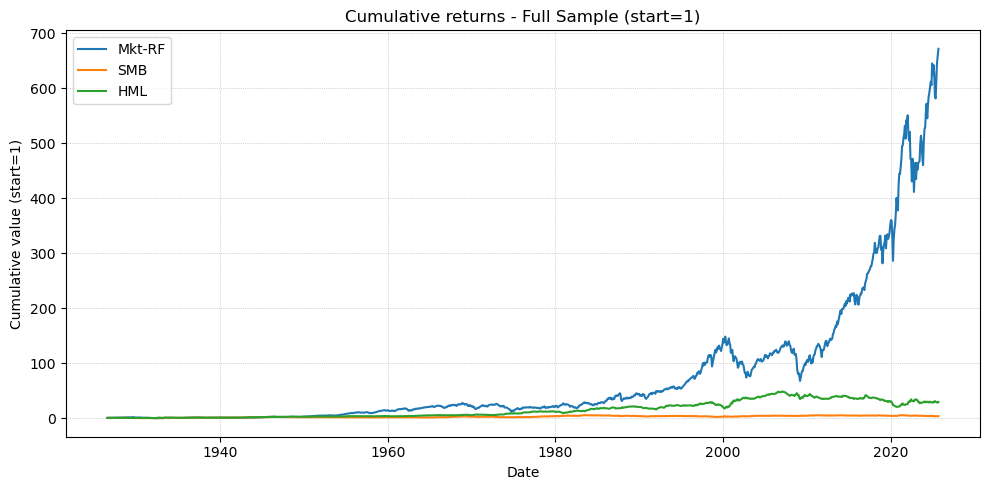

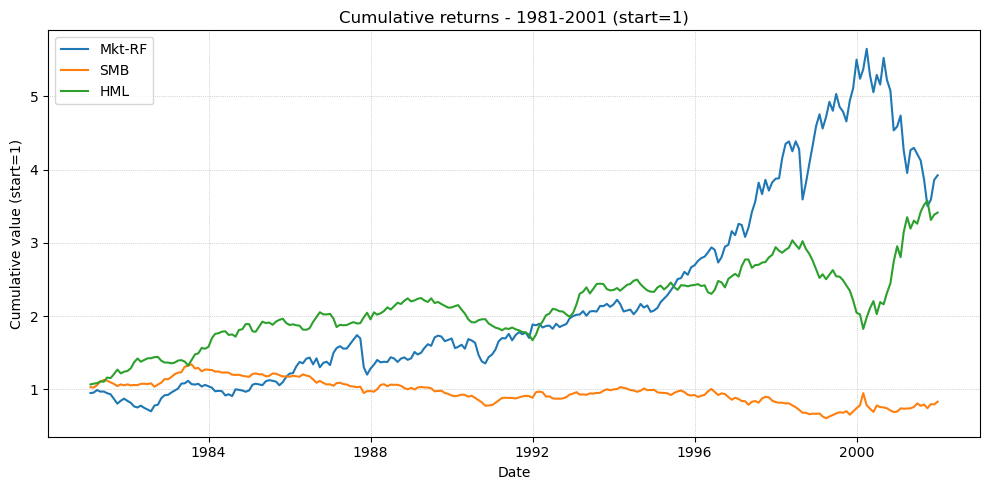

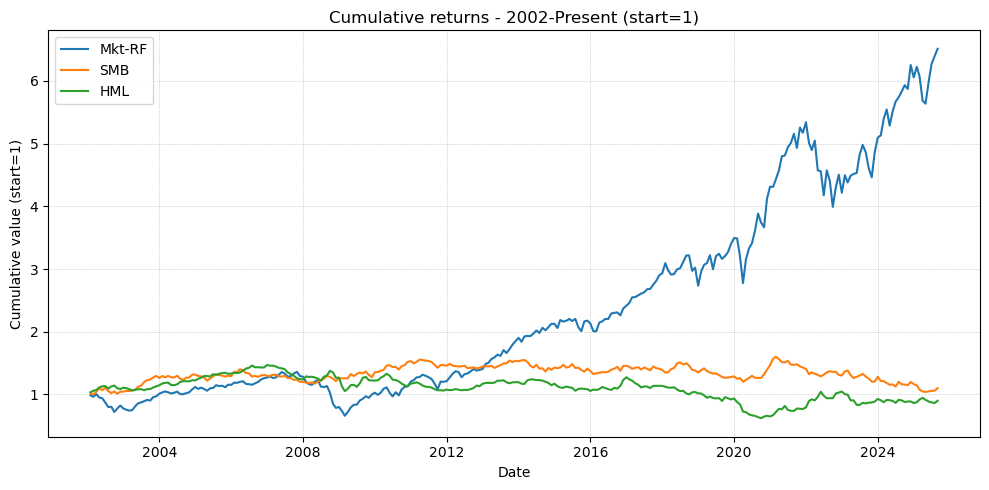

In [20]:
def plot_cumulative_returns(df: pd.DataFrame, factors: list = FACTORS,
                            title: str = "Cumulative returns", savepath: str = None):
    cum = (1 + df[factors]).cumprod()
    plt.figure(figsize=(10, 5))
    for f in factors:
        plt.plot(cum.index, cum[f], label=f)
    plt.legend()
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative value (start=1)")
    plt.grid(True, linestyle=':', linewidth=0.5)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()
    plt.close()

plot_cumulative_returns(df, title="Cumulative returns - Full Sample (start=1)", savepath="cum_full.png")
plot_cumulative_returns(subsamples["1981 - 2001"], title="Cumulative returns - 1981-2001 (start=1)", savepath="cum_1981_2001.png")
plot_cumulative_returns(subsamples["2002 - Present"], title="Cumulative returns - 2002-Present (start=1)", savepath="cum_2002_present.png")

## 5.

- Does it appear that all three factors were valuable in 1981-2001?
- And post-2001?

Would you advise DFA to continue emphasizing all three factors?

- 1981–2001: Value (HML) proved highly valuable during this cycle (with a significant positive premium and notable cumulative contribution), while Size (SMB) was unstable (even marginally negative). Therefore, emphasizing Value + Market during this period was more reasonable; equal weighting for Size may not have yielded additional gains.
- 2002–Present:
  - Market: Remains the dominant factor, delivering the best performance.
  - Size: Exhibits a marginal positive premium, but its magnitude is very small (annualized less than 1%), contributing little to long-term returns.
  - Value: Its premium has significantly diminished since the late 2000s (virtually zero from 2002 to present), weakening its status as a “long-term stable alpha” source (though note that value still exhibits significant reversion/reversal across different cycles).


Recommendations for DFA (Practical Level): Retain the three factors as a candidate pool (as they provide varying returns and hedging capabilities across different cycles), but employ dynamic weighting or risk budgeting methods to adjust the long-term position weights.

# 3. CAPM
DFA believes that premia in stocks and stock portfolios is related to the three factors.

Let’s test 25 equity portfolios that span a wide range of size and value measures.

In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from typing import Dict

DATA_PATH = "dfa_analysis_data.xlsx"
FACTORS_SHEET = "factors"
PORTFOLIOS_SHEET = "portfolios (total returns)"

SUB_START = "1981-01-01"  

factors = pd.read_excel(DATA_PATH, sheet_name=FACTORS_SHEET)
ports = pd.read_excel(DATA_PATH, sheet_name=PORTFOLIOS_SHEET)

factors['Date'] = pd.to_datetime(factors['Date'])
factors = factors.set_index('Date').sort_index()
ports['Date'] = pd.to_datetime(ports['Date'])
ports = ports.set_index('Date').sort_index()

portfolio_cols = [c for c in ports.columns]
print("Detected portfolio columns (count={}):".format(len(portfolio_cols)))
print(portfolio_cols)

for col in ['Mkt-RF', 'RF']:
    if col not in factors.columns:
        raise KeyError(f"Column '{col}' not found in {FACTORS_SHEET} sheet. Please check column names.")


Detected portfolio columns (count=25):
['SMALL LoBM', 'ME1 BM2', 'ME1 BM3', 'ME1 BM4', 'SMALL HiBM', 'ME2 BM1', 'ME2 BM2', 'ME2 BM3', 'ME2 BM4', 'ME2 BM5', 'ME3 BM1', 'ME3 BM2', 'ME3 BM3', 'ME3 BM4', 'ME3 BM5', 'ME4 BM1', 'ME4 BM2', 'ME4 BM3', 'ME4 BM4', 'ME4 BM5', 'BIG LoBM', 'ME5 BM2', 'ME5 BM3', 'ME5 BM4', 'BIG HiBM']


## 1. Summary Statistics.

For each portfolio,

- Use the Risk-Free rate column in the factors tab to convert these total returns to excess returns.
- Calculate the (annualized) univariate statistics from 1.1.

In [24]:
start = pd.to_datetime(SUB_START)

factors_sub = factors.loc[start:]
ports_sub = ports.loc[start:]

combined = ports_sub.join(factors_sub[['RF','Mkt-RF']], how='inner')  # inner join to keep common dates

excess = combined[portfolio_cols].subtract(combined['RF'], axis=0)

def univariate_stats(df_returns_monthly: pd.DataFrame, alpha=0.05):
    mean_m = df_returns_monthly.mean()
    vol_m = df_returns_monthly.std()
    sharpe_m = mean_m / vol_m
    var05_m = df_returns_monthly.quantile(alpha)  # e.g. 5% historical VaR

    mean_a = mean_m * 12
    vol_a = vol_m * np.sqrt(12)
    sharpe_a = mean_a / vol_a

    stats = pd.DataFrame({
        'Mean (m)': mean_m,
        'Vol (m)': vol_m,
        'Sharpe (m)': sharpe_m,
        'VaR(5%) (m)': var05_m,
        'Mean (a)': mean_a,
        'Vol (a)': vol_a,
        'Sharpe (a)': sharpe_a
    })
    return stats

stats_1981_present = univariate_stats(excess)
stats_1981_present.round(6)

,Mean (m),Vol (m),Sharpe (m),VaR(5%) (m),Mean (a),Vol (a),Sharpe (a)
SMALL LoBM,0.000975,0.078444,0.012435,-0.124886,0.011705,0.271737,0.043075
ME1 BM2,0.007370,0.067963,0.108438,-0.094929,0.088438,0.235431,0.375641
ME1 BM3,0.007519,0.057976,0.129690,-0.084816,0.090226,0.200834,0.449260
ME1 BM4,0.009378,0.056012,0.167428,-0.077604,0.112535,0.194031,0.579986
SMALL HiBM,0.010610,0.060147,0.176395,-0.088174,0.127314,0.208354,0.611049
ME2 BM1,0.005077,0.070630,0.071880,-0.103232,0.060922,0.244669,0.248999
ME2 BM2,0.008197,0.059285,0.138264,-0.083392,0.098365,0.205371,0.478962
ME2 BM3,0.008763,0.053818,0.162825,-0.080313,0.105155,0.186431,0.564042
ME2 BM4,0.009006,0.052501,0.171536,-0.075338,0.108069,0.181868,0.594217
ME2 BM5,0.009433,0.061677,0.152938,-0.093275,0.113192,0.213654,0.529793


## 2. CAPM

In [ ]:
mkt_excess = combined['Mkt-RF'] 

results = []

for col in portfolio_cols:
    y = excess[col].dropna()
    x = mkt_excess.reindex(y.index) 
    X = sm.add_constant(x)
    model = sm.OLS(y, X, missing='drop')
    res = model.fit()
    alpha_m = res.params['const']      
    beta = res.params['Mkt-RF']        
    resid_std_m = res.resid.std()
    mean_ret_m = y.mean()

    alpha_a = alpha_m * 12
    mean_ret_a = mean_ret_m * 12
    resid_std_a = resid_std_m * np.sqrt(12)

    treynor = mean_ret_a / beta if beta != 0 else np.nan
    info_ratio = alpha_a / resid_std_a if resid_std_a > 0 else np.nan

    t_alpha = res.tvalues['const']
    t_beta = res.tvalues['Mkt-RF']
    rsq = res.rsquared
    n_obs = int(res.nobs)

    results.append({
        'portfolio': col,
        'alpha_m': alpha_m,
        'alpha_a': alpha_a,
        'beta': beta,
        'mean_ret_m': mean_ret_m,
        'mean_ret_a': mean_ret_a,
        'resid_std_m': resid_std_m,
        'resid_std_a': resid_std_a,
        'treynor_a': treynor,
        'info_ratio': info_ratio,
        't_alpha': t_alpha,
        't_beta': t_beta,
        'rsq': rsq,
        'n_obs': n_obs
    })

results_df = pd.DataFrame(results).set_index('portfolio')
results_df = results_df.sort_index()
results_df.round(6)

,alpha_m,alpha_a,beta,mean_ret_m,mean_ret_a,resid_std_m,resid_std_a,treynor_a,info_ratio,t_alpha,t_beta,rsq,n_obs
portfolio,,,,,,,,,,,,,
BIG HiBM,0.001363,0.016354,1.025974,0.008629,0.103542,0.036837,0.127606,0.100921,0.128162,0.845223,28.821525,0.608700,536
BIG LoBM,0.000856,0.010270,0.995470,0.007905,0.094866,0.015389,0.053309,0.095297,0.192647,1.270501,66.938399,0.893514,536
ME1 BM2,-0.000886,-0.010629,1.165759,0.007370,0.088438,0.043518,0.150750,0.075863,-0.070510,-0.465009,27.720589,0.589997,536
ME1 BM3,0.000087,0.001039,1.049509,0.007519,0.090226,0.033947,0.117596,0.085970,0.008831,0.058241,31.992234,0.657144,536
ME1 BM4,0.002457,0.029481,0.977337,0.009378,0.112535,0.034956,0.121091,0.115145,0.243461,1.605614,28.932432,0.610528,536
ME2 BM1,-0.004371,-0.052447,1.334065,0.005077,0.060922,0.037679,0.130523,0.045667,-0.401824,-2.650013,36.638765,0.715412,536
ME2 BM2,0.000131,0.001576,1.138954,0.008197,0.098365,0.030223,0.104697,0.086364,0.015050,0.099255,38.996199,0.740108,536
ME2 BM3,0.001429,0.017142,1.035676,0.008763,0.105155,0.027303,0.094579,0.101532,0.181248,1.195321,39.253738,0.742633,536
ME2 BM4,0.002091,0.025089,0.976453,0.009006,0.108069,0.029058,0.100659,0.110675,0.249250,1.643795,34.773675,0.693668,536


In [27]:
mae_monthly = results_df['alpha_m'].abs().mean()
mae_annualized = results_df['alpha_a'].abs().mean()
print(f"MAE (monthly alphas, mean |alpha_m|) = {mae_monthly:.6f}")
print(f"MAE (annualized alphas, mean |alpha_a|) = {mae_annualized:.6f}")

MAE (monthly alphas, mean |alpha_m|) = 0.001721
MAE (annualized alphas, mean |alpha_a|) = 0.020651


## 3. Cross-sectional Estimation

In [33]:
cross_beta = results_df['beta']          
cross_mean = results_df['mean_ret_a']     

cs_df = pd.DataFrame({'beta': cross_beta, 'mean_ret_a': cross_mean}).dropna()

X_cs = sm.add_constant(cs_df['beta'])
y_cs = cs_df['mean_ret_a']
cs_model = sm.OLS(y_cs, X_cs).fit()


r2_cs = cs_model.rsquared
eta = cs_model.params['const']
lambda_mkt = cs_model.params['beta']

print(f"\nR-squared = {r2_cs:.6f}")
print(f"Intercept = {eta:.6f} (annualized)")
print(f"Regression coefficient = {lambda_mkt:.6f} (annualized price of market risk)")


R-squared = 0.313153
Intercept = 0.205842 (annualized)
Regression coefficient = -0.105912 (annualized price of market risk)


## 4. Conclusion

Broadly speaking, do these results support DFA’s belieef in size and value portfolios containing premia unrelated to the market premium?

The CAPM results do not provide strong support for DFA’s belief. Across the 25 portfolios, market beta alone does not fully explain the cross-section of excess returns — many portfolios exhibit statistically meaningful alphas, and factor premia appear correlated with size and value characteristics rather than only market exposure. This suggests that the size (SMB) and value (HML) factors contain return premia that are not captured by the market factor, consistent with DFA’s multi-factor perspective and inconsistent with a strict CAPM world.